Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'CLTV', 'Recency',
       'Frequency', 'Monetary', 'Region_Encoded'],
      dtype='object')
CustomerID        0
CustomerName      0
Region            0
SignupDate        0
CLTV              1
Recency           1
Frequency         1
Monetary          1
Region_Encoded    0
dtype: int64


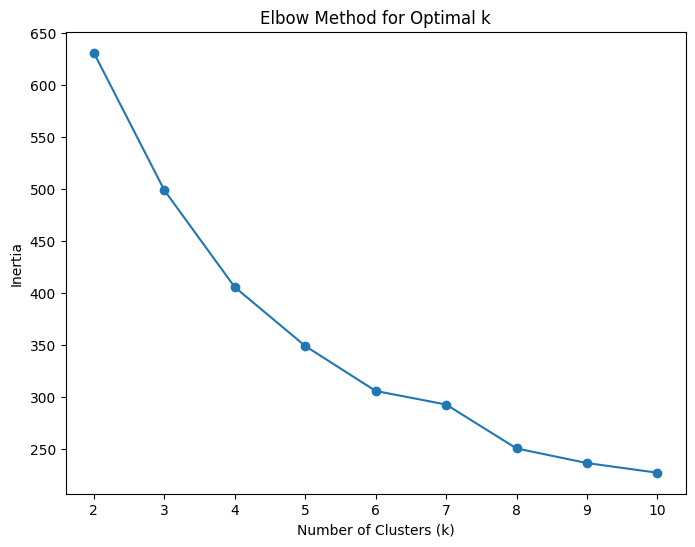

Davies-Bouldin Index: 1.093709989997279
Silhouette Score: 0.30856029431266585


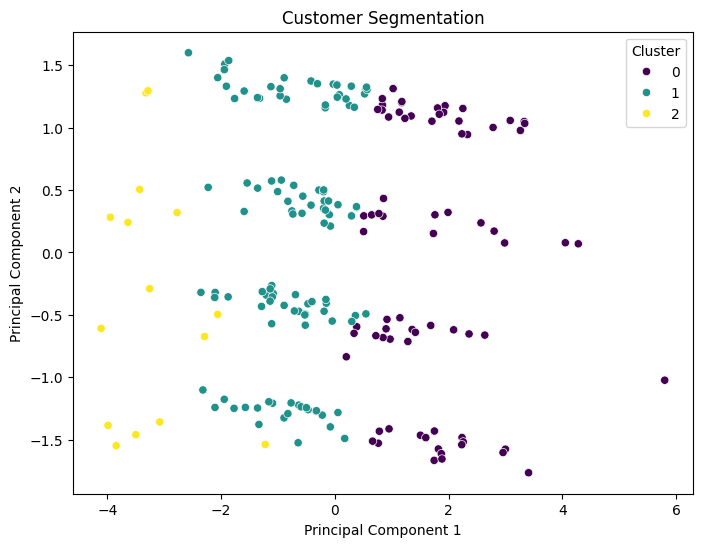


Cluster 0 Characteristics:
       Region_Encoded     Recency  Frequency      Monetary          CLTV
count       73.000000   73.000000  73.000000     73.000000     73.000000
mean         1.643836   54.684932   7.054795   5390.120548   5390.120548
std          1.182862   45.604239   1.606328   1228.911329   1228.911329
min          0.000000    0.000000   4.000000   2948.440000   2948.440000
25%          1.000000   13.000000   6.000000   4612.440000   4612.440000
50%          2.000000   47.000000   7.000000   5231.260000   5231.260000
75%          3.000000   86.000000   8.000000   6000.560000   6000.560000
max          3.000000  232.000000  11.000000  10673.870000  10673.870000

Cluster 1 Characteristics:
       Region_Encoded     Recency   Frequency     Monetary         CLTV
count      112.000000  112.000000  112.000000   112.000000   112.000000
mean         1.616071   62.365084    4.160939  2554.244146  2554.244146
std          1.108896   47.445505    1.332714   885.791567   885.791567

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Convert 'TransactionDate' to datetime for correct analysis
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Feature Engineering
# 1. Calculate customer lifetime value (CLTV)
customer_cltv = transactions_df.groupby('CustomerID')['TotalValue'].sum()
# Merge the CLTV into the customers_df
customers_df = customers_df.merge(customer_cltv, on='CustomerID', how='left')
customers_df.rename(columns={'TotalValue': 'CLTV'}, inplace=True)  # Ensure the column is named 'CLTV'

# 2. Calculate customer recency, frequency, and monetary value (RFM)
rfm_df = transactions_df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (transactions_df['TransactionDate'].max() - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'TotalValue': 'sum'  # Monetary
})
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
# Merge RFM features into customers_df
customers_df = customers_df.merge(rfm_df, on='CustomerID', how='left')

# 3. Encode categorical variables (Region)
customers_df['Region_Encoded'] = customers_df['Region'].astype('category').cat.codes

# Check if the 'CLTV' column exists
print(customers_df.columns)

# Check for missing values (NaNs)
print(customers_df.isna().sum())

# Handle NaNs: Impute with mean for numeric columns ONLY
# Select only numeric columns for imputation
numeric_features = customers_df.select_dtypes(include=['number']).columns
customers_df[numeric_features] = customers_df[numeric_features].fillna(customers_df[numeric_features].mean())

# Alternatively, Option 2: Drop rows with any NaN values
# customers_df.dropna(inplace=True)

# Select features for clustering
features = ['Region_Encoded', 'Recency', 'Frequency', 'Monetary', 'CLTV']

# Ensure the features exist in the dataframe before proceeding
missing_features = [feature for feature in features if feature not in customers_df.columns]
if missing_features:
    raise ValueError(f"The following features are missing from the dataframe: {missing_features}")

X = customers_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method to help choose the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Based on the elbow method, choose the optimal number of clusters
n_clusters = 3

# Create and fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the DataFrame
customers_df['Cluster'] = kmeans.labels_

# Calculate clustering metrics
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
silhouette = silhouette_score(X_scaled, kmeans.labels_)

# Print clustering metrics
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

# Visualize clusters (2D scatter plot using PCA)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=customers_df['Cluster'], palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segmentation')
plt.show()

# Analyze cluster characteristics
for i in range(n_clusters):
    print(f"\nCluster {i} Characteristics:")
    print(customers_df[customers_df['Cluster'] == i][features].describe())

# Report
print(f"\nNumber of Clusters: {n_clusters}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

# Interpretation:
# - Analyze the characteristics of each cluster (e.g., average RFM values, dominant region).
# - Develop customer profiles for each cluster.
# - Use these insights for targeted marketing campaigns, product recommendations, and customer retention strategies.